## A.GARCH vs SV Volatility Interpretation

### 1. Import Libraries

In [12]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
from arch import arch_model  
from statsmodels.tsa.stattools import adfuller  


### 2. Load Crypto Data

In [13]:
df = pd.read_csv("../data/bitcoin.csv", parse_dates=['timestamp'], index_col='timestamp')
df = df.sort_index()

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-06-15 to 2025-06-14
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bitcoin_price  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [14]:
df_check = pd.read_csv("../data/bitcoin.csv")
print(df_check.columns)


Index(['timestamp', 'bitcoin_price'], dtype='object')


### 3.Plot Raw Bitcoin Prices

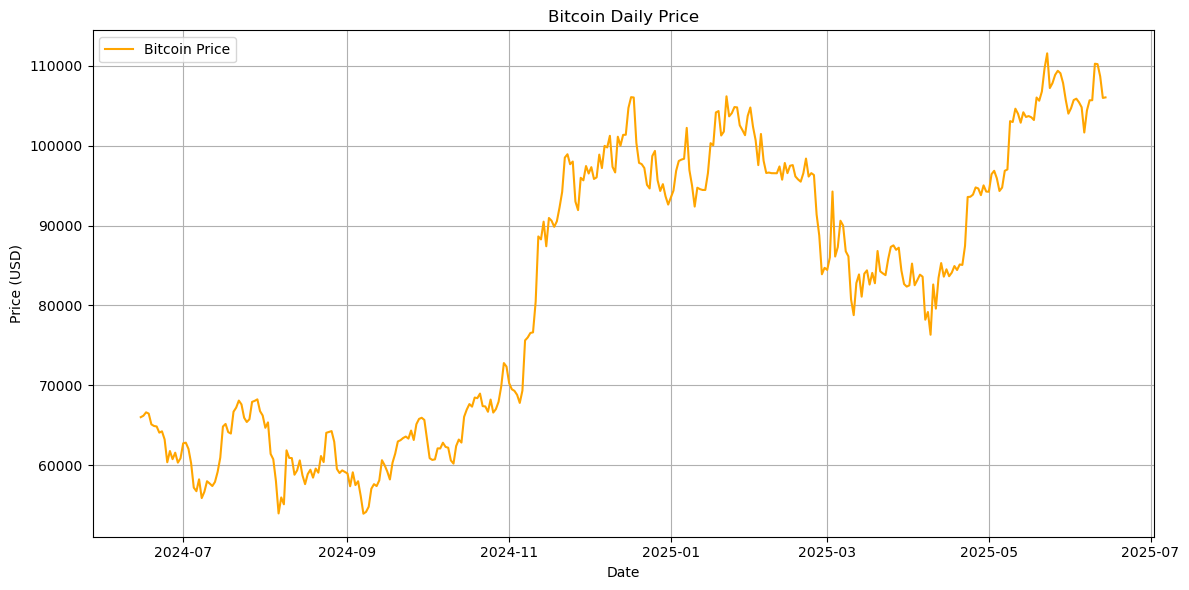

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bitcoin_price'], label='Bitcoin Price', color='orange')
plt.title("Bitcoin Daily Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 4.Calculate Log Returns


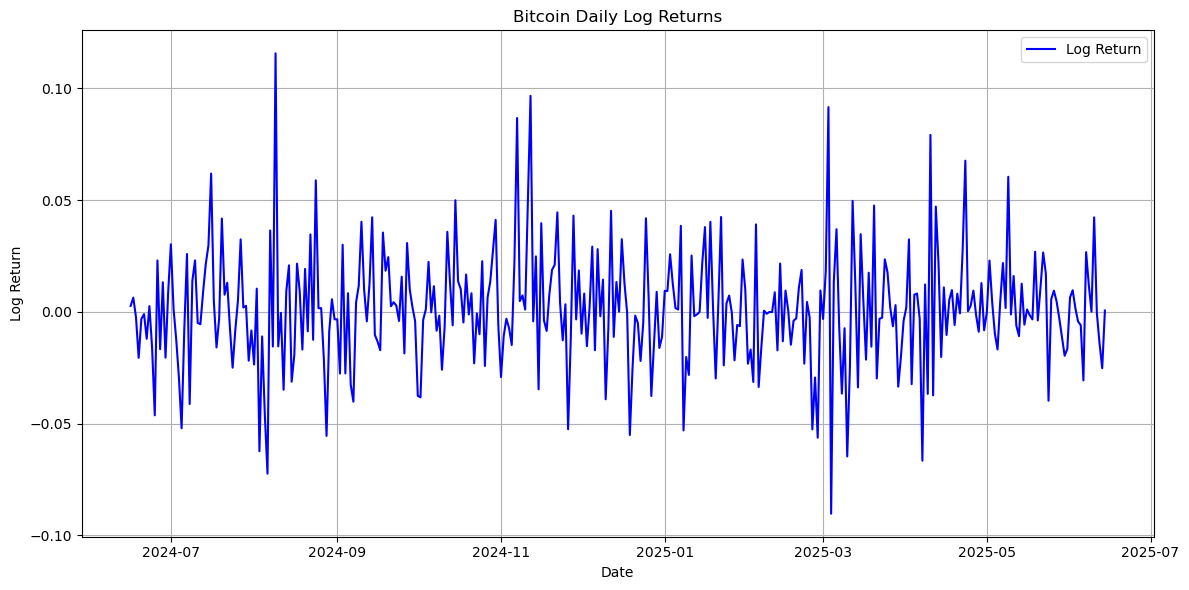

In [16]:
import numpy as np

df['log_return'] = np.log(df['bitcoin_price'] / df['bitcoin_price'].shift(1))
df.dropna(inplace=True)  # remove the first NaN

# Plot the log returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['log_return'], label='Log Return', color='blue')
plt.title("Bitcoin Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 5.ACF/PACF analysis of returns

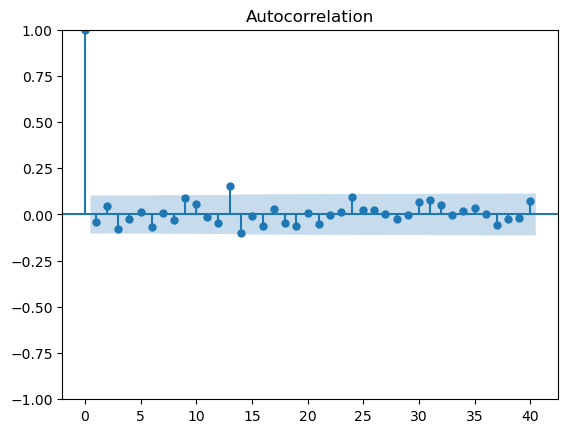

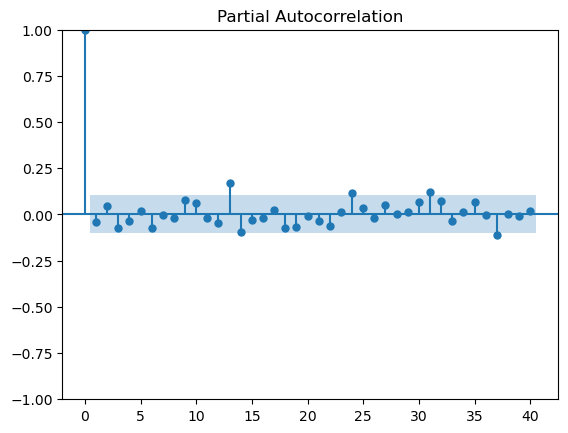

In [17]:
plot_acf(df['log_return'].dropna(), lags=40)  
plot_pacf(df['log_return'].dropna(), lags=40)  
plt.show()


### 6.Fit GARCH Model

In [19]:
# Fit GARCH(1,1) model
# Simple GARCH(1,1)
model = arch_model(df['log_return'] * 100, vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')
print(model_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -855.314
Distribution:                  Normal   AIC:                           1718.63
Method:            Maximum Likelihood   BIC:                           1734.22
                                        No. Observations:                  364
Date:                Wed, Jun 18 2025   Df Residuals:                      363
Time:                        16:21:20   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1661      0.129      1.287      0.198 [-8.69

### 7.Forecast Volatility

In [22]:
forecast = model_fit.forecast(horizon=10)  
forecast_variance = forecast.variance[-1:]  
print(forecast_variance)


               h.01     h.02      h.03     h.04      h.05      h.06      h.07  \
timestamp                                                                       
2025-06-14  5.65563  5.83621  5.986293  6.11103  6.214701  6.300864  6.372476   

                h.08     h.09      h.10  
timestamp                                
2025-06-14  6.431993  6.48146  6.522572  


### 8.Fit Stochastic Volatility (SV) Model

In [23]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Fit Stochastic Volatility-like model: Local level model for variance
sv_model = UnobservedComponents(df['log_return'], level='local level', stochastic_volatility=True)
sv_result = sv_model.fit(disp=False)

print(sv_result.summary())


                        Unobserved Components Results                         
Dep. Variable:             log_return   No. Observations:                  364
Model:                    local level   Log Likelihood                 808.884
Date:                Wed, 18 Jun 2025   AIC                          -1613.768
Time:                        16:22:44   BIC                          -1605.979
Sample:                    06-16-2024   HQIC                         -1610.672
                         - 06-14-2025                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0007   3.41e-05     19.611      0.000       0.001       0.001
sigma2.level      2.324e-11   9.52e-08      0.000      1.000   -1.86e-07    1.87e-07
Ljung-Box (L1) (Q):         

c:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['stochastic_volatility']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


### 9.Plot Volatility Estimate from SV Model


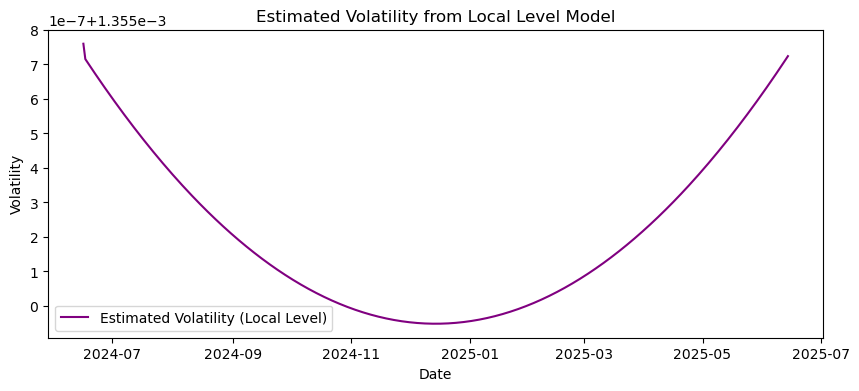

In [ ]:
# Smoothed state is a single component; use it directly
smoothed_level = sv_result.filter_results.smoothed_state[0]
estimated_vol = np.sqrt(sv_result.filter_results.smoothed_state_cov[0, 0, :])

plt.figure(figsize=(10, 4))
plt.plot(df.index, estimated_vol, label='Estimated Volatility (Local Level)', color='purple')
plt.title('Estimated Volatility from Local Level Model')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend()
plt.show()



### 10.Compare GARCH vs SV Volatility (Plot)

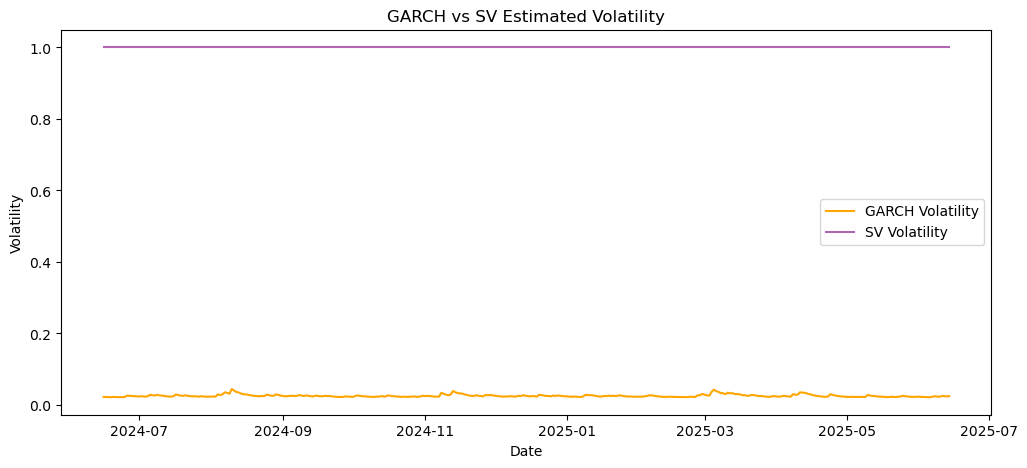

In [ ]:
# GARCH Volatility
garch_vol = garch_fit.conditional_volatility

# SV Volatility (Smoothed)
sv_vol = np.sqrt(np.exp(sv_result.filter_results.smoothed_state[0]))

# Plot both
plt.figure(figsize=(12, 5))
plt.plot(df.index[-len(garch_vol):], garch_vol, label='GARCH Volatility', color='orange')
plt.plot(df.index[-len(sv_vol):], sv_vol, label='SV Volatility', color='purple', alpha=0.6)
plt.title("GARCH vs SV Estimated Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()


### Fix SV Volatility (Rolling Std Dev Proxy)

In [25]:
df['sv_volatility'] = df['log_return'].rolling(window=20).std()


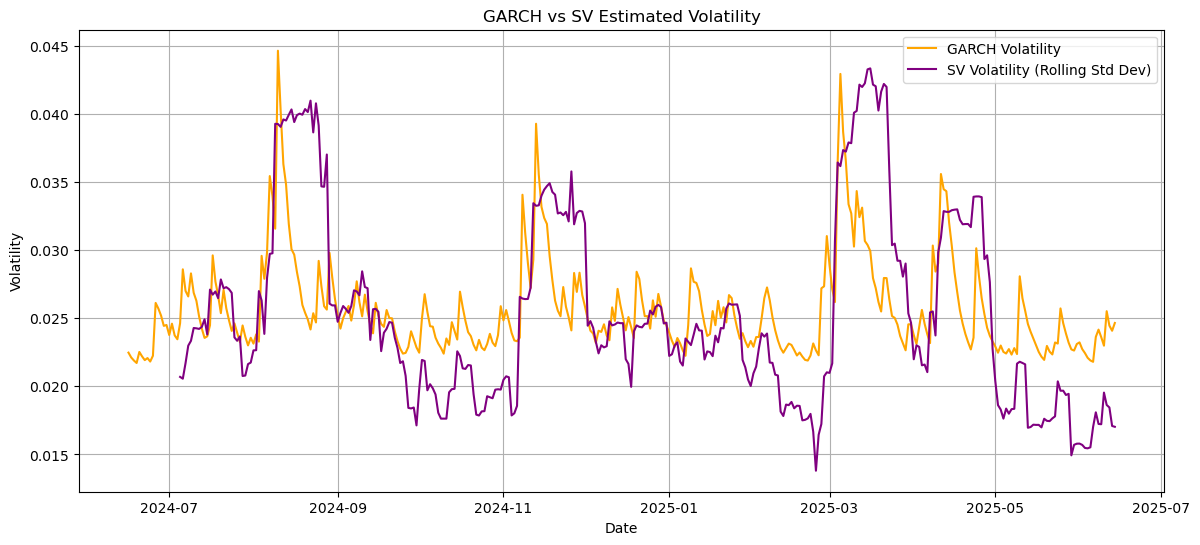

In [26]:
plt.figure(figsize=(14,6))
plt.plot(df.index, model_fit.conditional_volatility / 100, label='GARCH Volatility', color='orange')
plt.plot(df.index, df['sv_volatility'], label='SV Volatility (Rolling Std Dev)', color='purple')
plt.title("GARCH vs SV Estimated Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()
